## HW: Modelling a local circuit

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sdorkenw/AMATH_342_neuronal_circuits/blob/main/Modelling_local_circuits_HW.ipynb)

In the class notebook, we implemented a firing rate model and used it to simulate impulse responses. In this homework, we probe this model further by making changes to its parameters and testing the impact of small changes to the observed circuit.

In [1]:
# Data paths
syn_data_url = f"https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/synapses_proofread_V1_neurons_1300.feather"
cell_data_url = f"https://github.com/sdorkenw/MICrONS_workshop_CNC_forum/raw/refs/heads/main/data/cell_info_1300.feather"

## Import & Installs

In [2]:
%%capture
!pip install networkx

In [3]:
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns

# Numerical analysis
import numpy as np

# Data handling
import pandas as pd
import collections

# Graph analysis and random graph generators
import networkx as nx

## Plotting and analysis helpers from the class notebook

In [4]:
def plot_matrix(W: np.ndarray):
    """ Plots a connectivity matrix

    Args:
        W: a weight matrix

    """

    W_extreme_val = np.percentile(np.abs(W[W != 0]), 95) * 1.01
    fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
    im = ax.imshow(W.T, vmin=-W_extreme_val, vmax=W_extreme_val, cmap="bwr")

    ax.set_xlabel("Postsynaptic neurons", fontsize=12)
    ax.set_ylabel("Presynaptic neurons", fontsize=12)

    cbar = fig.colorbar(im, ax=ax, shrink=.5)
    cbar.ax.tick_params(labelsize=8)
    cbar.set_label('Weight (AU)', labelpad=15)

    plt.show()


def plot_synapse_size_distribution(W: np.ndarray, non_zero_only: bool=True):
    """ Plots the distribution of synapse sizes

    Args:
        W: a weight matrix
        non_zero_only: If True, zero weights are not included in the plot

    """


    weights = W.flatten()

    if non_zero_only:
        weights = weights[weights != 0]

    W_extreme_val = np.percentile(np.abs(weights[weights != 0]), 99) * 1.01

    fig, ax = plt.subplots(figsize=(6, 3), dpi=150)

    sns.histplot(x=weights, bins=np.linspace(-W_extreme_val, W_extreme_val, 101), ax=ax)
    ax.set_xlabel("Weight (AU)", fontsize=12)
    ax.set_ylabel("Connection count", fontsize=12)
    plt.show()

In [5]:
def calculate_time_to_before(r: np.ndarray, dt: float, stimulus: np.ndarray, threshold_ratio: float=.01):
    """ Calculates time for activity to reach a pre-stimulus level

    Args:
        r: rates, shape: [n_neurons, n_steps]
        dt: step size in s
        stimulus: stimulus, shape: [n_neurons, n_steps]
        threshold_ratio: determines the cutoff at which we assume the response to have returned to a pre-stimulus level
    Returns:
        Timepoint, delta T
    """

    stimulus_m = stimulus[0] > 0
    stimulus_start = np.where(stimulus_m)[0][0]
    stimulus_end = np.where(stimulus_m)[0][-1]

    stimulus_strength = np.mean(stimulus[0][stimulus_m])
    t = np.arange(r.shape[1]) * dt

    avg_act_after_stimulus_series = np.mean(r[:, stimulus_end:], axis=0)
    act_before_stimulus = np.mean(r[:, stimulus_start - 1])

    r_threshold =  stimulus_strength * threshold_ratio + act_before_stimulus
    T = t[stimulus_end:][avg_act_after_stimulus_series < r_threshold][0]
    return T, T - stimulus_end * dt


def plot_time_series(r: np.ndarray, stimulus: np.ndarray, dt: float, r_inhibitory: float):
    """ Plots the time series

    Args:
        r: rates, shape: [n_neurons, n_steps]
        stimulus: stimulus, shape: [n_neurons, n_steps]
        dt: step size in s
        r_inhibitory: ratio of inhibitory neurons

    """

    n_neurons_exc = int(n_neurons * (1 - r_inhibitory))
    t = np.arange(r.shape[1]) * dt

    try:
        t_to_before, t_to_before_delta = calculate_time_to_before(r[:n_neurons_exc], dt, stimulus[:n_neurons_exc])
    except:
        t_to_before, t_to_before_delta = None, None

    fig, ax = plt.subplots(3, figsize=(8, 8), dpi=150)

    ax[0].set_title("Excitatory neurons")
    ax[0].plot(t, r[:n_neurons_exc, :].T, lw=1, alpha=.25)
    ax[0].plot(t, np.mean(r[:n_neurons_exc], axis=0), lw=2, c="k")
    ax[0].set_xlabel('time')
    ax[0].set_ylabel('r')

    if t_to_before is not None and t_to_before_delta > 0:
        ax[0].vlines(t_to_before, 0, np.max(r), ls="--", color="r")
        ax[0].text(t_to_before + 1, np.max(r)/2, f"$\Delta$t = {t_to_before_delta:.3f}s", color="r")

    ax[1].set_title("Inhibitory neurons")
    ax[1].plot(t, r[n_neurons_exc:, :].T, lw=1, alpha=.25)
    ax[1].plot(t, np.mean(r[n_neurons_exc:], axis=0), lw=2, c="k")
    ax[1].set_xlabel('time')
    ax[1].set_ylabel('r')

    ax[2].set_title("Stimulus signal to excitatory neurons")
    ax[2].plot(t, np.mean(stimulus[:n_neurons_exc], axis=0), lw=2, c="k")
    ax[2].set_xlabel('time')
    ax[2].set_ylabel('Input')

    plt.tight_layout()
    plt.show()

In [6]:
def generate_stimulus(n_neurons: int, n_steps: int, r_inhibitory: float, stim_strength: float, t_input_start: float,
                      t_stimulus_end: float, dt: float):
    """ Generates stimulus array

    Args:
        n_neurons: Number of neurons
        n_steps: Number of steps
        r_inhibitory: Ratio of inhibitory neurons
        stim_strength: Stimulus strength
        t_input_start: Stimulus start time in s
        t_input_end: Stimulus end time in s
        dt: Time step

    Returns:
        stimulus, shape: [n_neurons, n_steps]
    """
    n_neurons_exc = int(n_neurons * (1 - r_inhibitory))

    stimulus = np.zeros([n_neurons, n_steps])

    t = np.arange(n_steps) * dt
    mask = np.logical_and(t >= t_stimulus_start, t <= t_stimulus_end)
    stimulus[:, mask] = stim_strength
    stimulus[n_neurons_exc:] = 0

    return stimulus

def transfer_func(x: np.ndarray, act_func: str="linear"):
    """ Applies an activation function the pre-activity.

    Args:
        pre_act: 'activity' before applying an activation function
        act_func: activiation function, 'relu' and 'linear' are supported
    """

    if act_func == "linear":
        z = x
    elif act_func == "relu":
        z = np.maximum(0, x)
    else:
        assert("Activation function not defined.")
    return z

def run_simulation(W: np.ndarray, stimulus: np.ndarray, dt: float=.01, tau: float=.25, act_func: str="relu"):
    """ Runs a simuluation using the Euler Method for a number of steps

    Args:
        W: a weight matrix
        stimulus: stimulus array
        dt: time step
        tau: time constant
        act_func: activiation function, 'relu' and 'linear' are supported

    Returns:
        r: firing rates
    """
    n_neurons = W.shape[0]
    n_steps = stimulus.shape[1]
    r = np.zeros([n_neurons, n_steps])

    for step in range(0, n_steps - 1):
        pre_act = np.matmul(W, r[:, step]) + stimulus[:, step]
        r[:, step+1] = r[:, step] + (-r[:, step] + transfer_func(pre_act, act_func=act_func)) * dt / tau

    return r

## Data Loading and matrix builder

In [7]:
def filter_synapse_table(synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        pre_m = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_m = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        post_m = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_m = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_m & post_m]


def input_balance_excitation_inhibition(W: np.ndarray, n_neurons_exc: int, inh_exc_balance: float=1):
    """ Balances E and I on the input side of every neuron

    Args:
        W: a weight matrix
        n_neurons_exc: number of excitatory neurons in the matrix (first n_neurons_exc are assumed to be the excitatory neurons)
        inh_exc_balance: how to balabce E and I. A value of 1 balances E and I equally; a lower value will weight E higher.

    Returns:
        W_bal: a balanced weight matrix
    """
    W_bal = W.copy()

    per_neuron_exc_input_sum = np.sum(W[:, :n_neurons_exc], axis=1)
    per_neuron_inh_input_sum = np.sum(W[:, n_neurons_exc:], axis=1)

    per_neuron_inh_input_sum[per_neuron_inh_input_sum == 0] = 1 # stable behavior

    inh_scale_up = per_neuron_exc_input_sum / -per_neuron_inh_input_sum * inh_exc_balance
    W_bal[:, n_neurons_exc:] *= inh_scale_up[:, None]
    return W_bal


def observed_plus_random_connectivity_matrix(syn_mat: np.ndarray, r_inhibitory: float, g: float,
                                             connectivity_proba: float, random_seed: int, balance_W: bool=True,
                                             inh_exc_balance: float=1):
    """ Generates random connectivity matrix while using observed connectivity for EE portion

    Args:
        syn_mat: observed connectivity matrix
        r_inhibitory: ratio of inhibitory neurons
        g: gain
        connectivity_proba: probability of two neurons to be connected (directed)
        random_seed: random seed
        balance_W: whether to balance E and I weights on the input side of every neuron
        inh_exc_balance: how to balance E and I. A value of 1 balances E and I equally; a lower value will weight E higher.

    Returns:
        W: a balanced weight matrix
    """
    n_neurons = int(len(syn_mat) / (1 - r_inhibitory))
    n_neurons_exc = len(syn_mat)

    # Random Erdos Renyi graph
    er_graph = nx.erdos_renyi_graph(n_neurons, p=connectivity_proba, seed=random_seed, directed=True)
    W_er = nx.to_numpy_array(er_graph)

    # EE mask
    EE_mask = np.zeros_like(W_er, dtype=bool)
    EE_mask[:n_neurons_exc, :n_neurons_exc] = True

    # Random log-normally distributed weights
    random_state = np.random.RandomState(random_seed)
    W = g * 10**np.abs(random_state.normal(1, .2, (n_neurons, n_neurons)))
    W[~EE_mask] *= W_er[~EE_mask]

    # Plug in observed matrix
    W[EE_mask] = syn_mat.T.flatten() * g

    # Enforce Dale's law
    W[:, n_neurons_exc:] = -1 * W[:, n_neurons_exc:]

    # Balance weights and ensure equal balance for all neurons
    if balance_W:
        W = input_balance_excitation_inhibition(W, n_neurons_exc, inh_exc_balance=inh_exc_balance)
    return W


def shuffle_W_weights(W: np.ndarray, random_seed: int):
    """ Shuffles the weights in a matrix

    This function does not change which neurons are connected, only the weight of the connection.

    Args:
        W: a weight matrix
        random_seed: random seed

    Returns:
        W_s: weight shuffled matrix

    """

    W_s = W.copy()
    mat_weights = W_s[W_s > 0].flatten()
    np.random.RandomState(random_seed).shuffle(mat_weights)
    W_s[W_s > 0] = mat_weights
    return W_s


def shuffle_W_conns(W, random_seed):
    """ Shuffles the connections in a matrix

    Args:
        W: a weight matrix
        random_seed: random seed

    Returns:
        W_s: shuffled weight matrix

    """
    W_s = W.copy()
    W_s = W_s.flatten()
    np.random.RandomState(random_seed).shuffle(W_s)
    W_s = W_s.reshape(W.shape)
    return W_s


In [8]:
mat_version = 1300

# Load synapse and cell table
syn_df = pd.read_feather(syn_data_url)
cell_df = pd.read_feather(cell_data_url)

# Gather proofread L2/3 neuron IDs and filter synapse table
neuron_ids = np.array(cell_df[np.array(cell_df["cell_type_auto"] == "23P") & np.array(cell_df["proofreading_strategy"] != "") & np.array(cell_df["region"] == "V1")]["pt_root_id"])
syn_df_l23 = filter_synapse_table(syn_df, neuron_ids, neuron_ids)

# Remove neurons that have only a few synapses in our network
neuron_ids, c = np.unique(syn_df_l23[["pre_pt_root_id", "post_pt_root_id"]], return_counts=True)
neuron_ids = neuron_ids[c > 20]
syn_df_l23 = filter_synapse_table(syn_df, neuron_ids, neuron_ids)

# Transform table to a matrix - synapses within a connection are summed
syn_mat_df_l23 = syn_df_l23.pivot_table(index="pre_pt_root_id", columns="post_pt_root_id",
                                        values="size", aggfunc=lambda x: np.sum(x)).fillna(0)

# Make square matrix
input_output_ids = syn_mat_df_l23.index[np.isin(syn_mat_df_l23.index, syn_mat_df_l23.columns)]
syn_mat_l23 = np.array(syn_mat_df_l23.reindex(input_output_ids).reindex(columns=input_output_ids)) / 300

## EX1: Multiple runs and comparison of results

In the lecture, we showed differences in the impulse response between the observed network and shuffled networks for a single random seed. Use `calculate_time_to_before` to get the timing results without having to create the time series plots.

In [9]:
random_seed = 0

In [10]:
# Connectivity parameters
g = .002  # overall gain of connectivity
connectivity_proba = .25 # Likelihood of two neurons to be connected with each other
r_inhibitory = .15 # Ratio of inhibitory neurons
inh_exc_balance = .15 # Result of I/E for every neuron's input

n_neurons_exc = len(syn_mat_l23)
n_neurons = int(n_neurons_exc / (1 - r_inhibitory)) # number of neurons

# Simulation parameters
t_max = 50 # Length of simulation
dt = 0.01 # Simulation time step
t_stimulus_start = 1 # Stimulus start time
t_stimulus_end = 15 # Stimulus end time
stim_strength = 10 # Stimulus strength rate
tau = .25 # Neuron time constant

# Simulation variables
n_steps = int(t_max / dt)
stimulus = generate_stimulus(n_neurons, n_steps, r_inhibitory, stim_strength, t_stimulus_start, t_stimulus_end, dt)

In [11]:
W = observed_plus_random_connectivity_matrix(syn_mat_l23, r_inhibitory=r_inhibitory, g=g,
                                             connectivity_proba=connectivity_proba, random_seed=random_seed,
                                             inh_exc_balance=inh_exc_balance)

r = run_simulation(W, stimulus, dt=dt, tau=tau)
delta_T = calculate_time_to_before(r=r[:n_neurons_exc], dt=dt, stimulus=stimulus)[1]

delta_T

15.900000000000002

In [12]:
W = observed_plus_random_connectivity_matrix(shuffle_W_conns(syn_mat_l23, random_seed=random_seed), r_inhibitory=r_inhibitory, g=g,
                                             connectivity_proba=connectivity_proba, random_seed=random_seed,
                                             inh_exc_balance=inh_exc_balance)

r = run_simulation(W, stimulus, dt=dt, tau=tau)
delta_T = calculate_time_to_before(r=r[:n_neurons_exc], dt=dt, stimulus=stimulus)[1]

delta_T

11.810000000000002

Rerun the simulation for at least 10 different random seeds and plot the results with a histogram plot (e.g., using `plt.hist()`). Plot two histograms in the same plot, one for the observed and one for the matrix shuffle.

Calculate the means and standard deviations for each distribution and summarize the results in a few sentences.

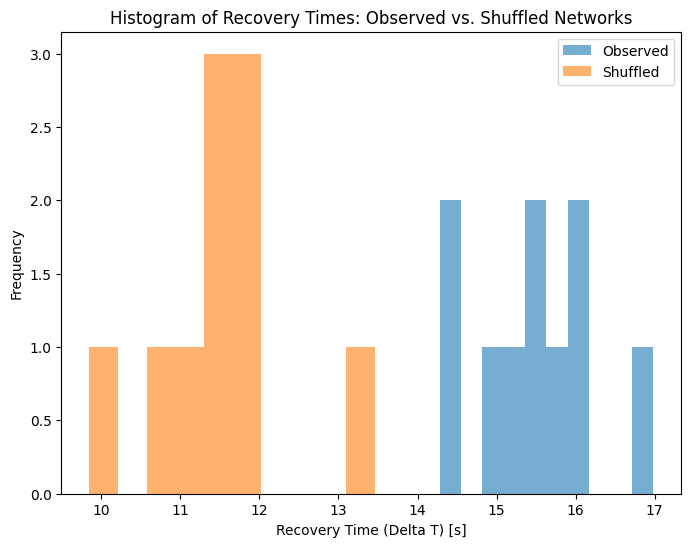

Observed Network: Mean delta_T = 15.428 s, Std = 0.772 s
Shuffled Network: Mean delta_T = 11.497 s, Std = 0.876 s


In [13]:
# TODO: your code goes here
# Lists to store delta T for observed and shuffled networks
observed_deltaT = []
shuffled_deltaT = []

# Run the simulation for each seed
for seed in range(10):
    # Observed connectivity matrix simulation
    W_obs = observed_plus_random_connectivity_matrix(syn_mat_l23,
                                                     r_inhibitory=r_inhibitory,
                                                     g=g,
                                                     connectivity_proba=connectivity_proba,
                                                     random_seed=seed,
                                                     inh_exc_balance=inh_exc_balance)
    r_obs = run_simulation(W_obs, stimulus, dt=dt, tau=tau)
    # calculate_time_to_before returns a tuple; we take the second value as delta_T
    delta_T_obs = calculate_time_to_before(r=r_obs[:n_neurons_exc], dt=dt, stimulus=stimulus)[1]
    observed_deltaT.append(delta_T_obs)

    # Shuffled connectivity matrix simulation
    W_shuffled = observed_plus_random_connectivity_matrix(shuffle_W_conns(syn_mat_l23, random_seed=seed),
                                                          r_inhibitory=r_inhibitory,
                                                          g=g,
                                                          connectivity_proba=connectivity_proba,
                                                          random_seed=seed,
                                                          inh_exc_balance=inh_exc_balance)
    r_shuffled = run_simulation(W_shuffled, stimulus, dt=dt, tau=tau)
    delta_T_shuffled = calculate_time_to_before(r=r_shuffled[:n_neurons_exc], dt=dt, stimulus=stimulus)[1]
    shuffled_deltaT.append(delta_T_shuffled)

# Convert lists to numpy arrays (if needed)
observed_deltaT = np.array(observed_deltaT)
shuffled_deltaT = np.array(shuffled_deltaT)

# Calculate means and standard deviations
mean_obs = np.mean(observed_deltaT)
std_obs = np.std(observed_deltaT)
mean_shuffled = np.mean(shuffled_deltaT)
std_shuffled = np.std(shuffled_deltaT)

# Plot histograms for both distributions
plt.figure(figsize=(8,6))
plt.hist(observed_deltaT, bins=10, alpha=0.6, label="Observed")
plt.hist(shuffled_deltaT, bins=10, alpha=0.6, label="Shuffled")
plt.xlabel("Recovery Time (Delta T) [s]")
plt.ylabel("Frequency")
plt.title("Histogram of Recovery Times: Observed vs. Shuffled Networks")
plt.legend()
plt.show()

# Print out the summary statistics
print("Observed Network: Mean delta_T = {:.3f} s, Std = {:.3f} s".format(mean_obs, std_obs))
print("Shuffled Network: Mean delta_T = {:.3f} s, Std = {:.3f} s".format(mean_shuffled, std_shuffled))

TODO: your summary goes here

In this exercise, we compared the network's recovery time between two cases: the observed network, which uses connectivity derived from real data, and the shuffled network, where the connectivity is randomized. I ran ten simulations with different random seeds for each case and plotted the resulting recovery times in the histogram. The observed network's recovery times tended to cluster at higher values, around 15-16 seconds, indicating that it took longer on average to return to baseline activity once the stimulus was removed. In contrast, the shuffled network's recovery times clustered at lower values, roughly 11-12 seconds, meaning that randomizing the connectivity allowed the network to decay to baseline faster. Overall, these results suggest that the structure in the observed network prolongs the response compared to a purely random arrangement of connections.

## EX2: Change a parameter and record the results

Choose a connectivity parameter (e.g., `connectivity_proba`) and measure the effect of changes to it by sampling at least 5 different values.

When pushed to the extreme, some parameters can cause the model to blowup (see example below for `connectivity_proba=0.1`). Find parameters for which the model activity converges within the range of simulated time and which show a notable difference in the measurements.

Use your code for multiple runs from EX1 to sample from at least 10 random seeds for each chosen value. Plot your result as a scatter plot (and an optional trendline) with the selected values on the x axis and the recorded times on the y axis. Discuss your results in a few sentences.

In [14]:
# Connectivity parameters
g = .002  # overall gain of connectivity
connectivity_proba = .1 # Likelihood of two neurons to be connected with each other
r_inhibitory = .15 # Ratio of inhibitory neurons
inh_exc_balance = .15 # Result of I/E for every neuron's input

n_neurons_exc = len(syn_mat_l23)
n_neurons = int(n_neurons_exc / (1 - r_inhibitory)) # number of neurons

# Simulation parameters
t_max = 50 # Length of simulation
dt = 0.01 # Simulation time step
t_stimulus_start = 1 # Stimulus start time
t_stimulus_end = 15 # Stimulus end time
stim_strength = 10 # Stimulus strength rate
tau = .25 # Neuron time constant

# Simulation variables
n_steps = int(t_max / dt)
stimulus = generate_stimulus(n_neurons, n_steps, r_inhibitory, stim_strength, t_stimulus_start, t_stimulus_end, dt)

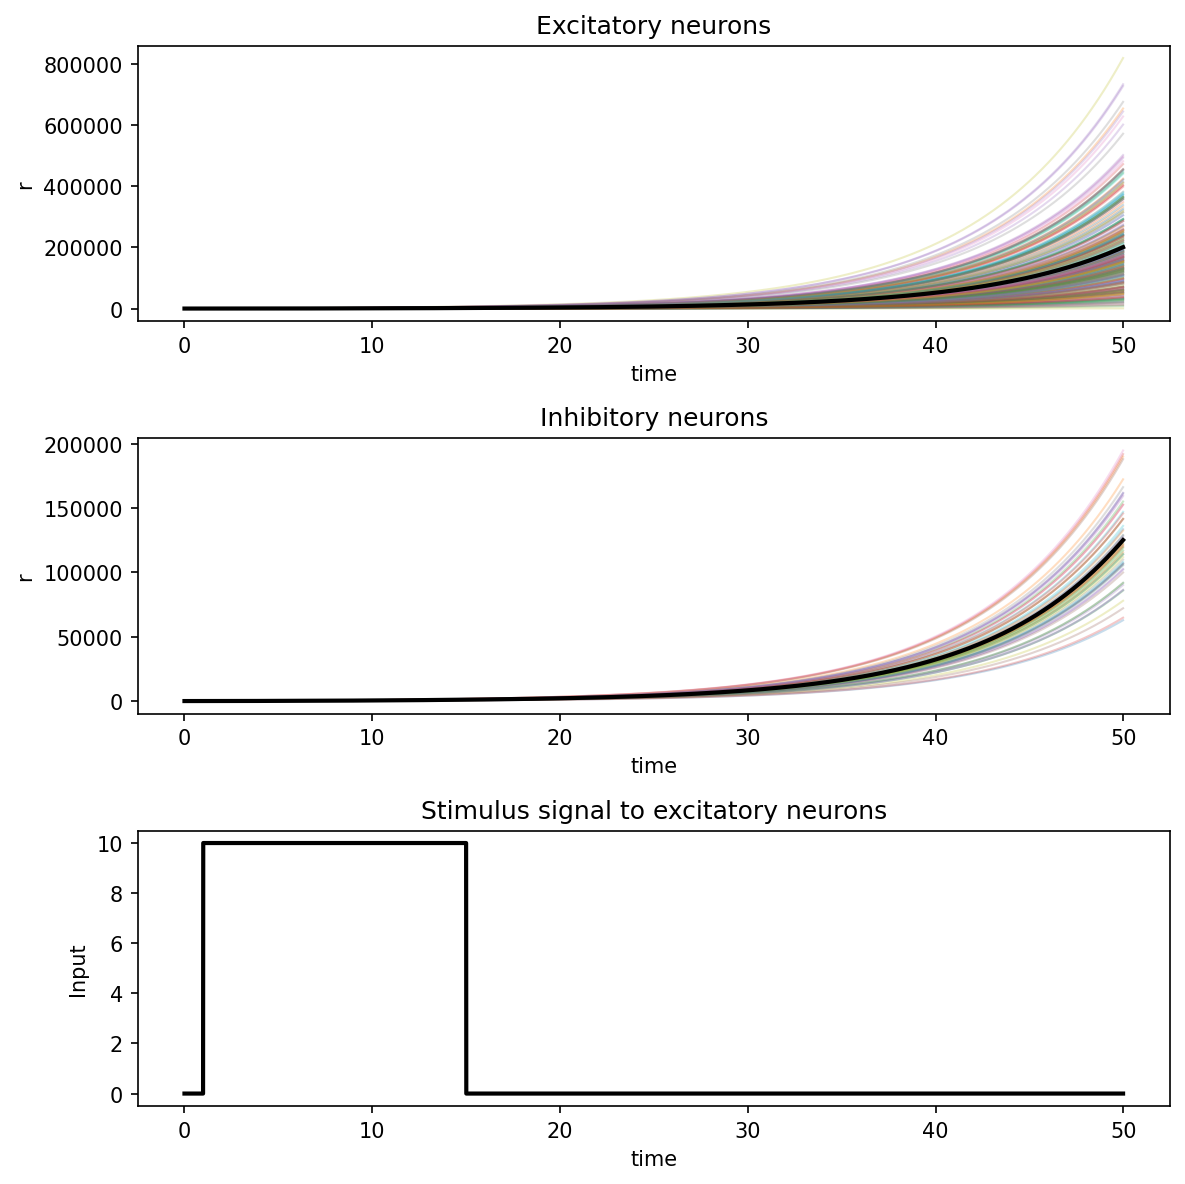

In [15]:
W = observed_plus_random_connectivity_matrix(syn_mat_l23, r_inhibitory=r_inhibitory, g=g,
                                             connectivity_proba=connectivity_proba, random_seed=random_seed,
                                             inh_exc_balance=inh_exc_balance)

# Run simulation
r = run_simulation(W, stimulus, dt=dt)

# Plot
plot_time_series(r, stimulus, dt, r_inhibitory)

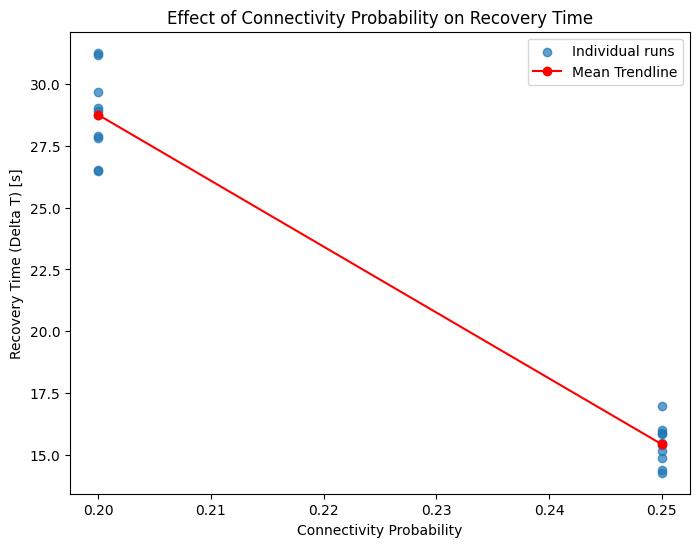

   Connectivity Probability  Mean Delta T  Std Delta T
0                      0.05           NaN          NaN
1                      0.10           NaN          NaN
2                      0.15           NaN          NaN
3                      0.20        28.748     1.580581
4                      0.25        15.428     0.772085


In [19]:
# TODO: your code goes here
conn_proba_values = [0.05, 0.1, 0.15, 0.2, 0.25]

num_seeds = 10  # Number of random seeds per connectivity probability value

# Lists to store results for scatter plot (each run)
all_conn_proba = []  # x-values: connectivity probability
all_deltaT = []     # y-values: recovery time (delta T)

# Loop over each connectivity probability value and for each value run simulation for multiple seeds
for conn_proba in conn_proba_values:
    for seed in range(num_seeds):
        # Generate a connectivity matrix using the current connectivity probability and random seed
        W_current = observed_plus_random_connectivity_matrix(
            syn_mat_l23,
            r_inhibitory=r_inhibitory,
            g=g,
            connectivity_proba=conn_proba,
            random_seed=seed,
            inh_exc_balance=inh_exc_balance
        )

        # Run the simulation with the generated matrix
        r_current = run_simulation(W_current, stimulus, dt=dt, tau=tau)
        # Calculate the recovery time (delta T) using only the excitatory neurons (first n_neurons_exc rows)
        try:
            t_to_before, t_to_before_delta = calculate_time_to_before(r=r_current[:n_neurons_exc], dt=dt, stimulus=stimulus)
        except:
            t_to_before, t_to_before_delta = None, np.nan  # or simply np.nan for delta T
        delta_T_current = t_to_before_delta

        # Append results to our lists
        all_conn_proba.append(conn_proba)
        all_deltaT.append(delta_T_current)

# Convert lists to numpy arrays for easier processing
all_conn_proba = np.array(all_conn_proba)
all_deltaT = np.array(all_deltaT)

# Create a scatter plot of connectivity probability vs. recovery time
plt.figure(figsize=(8,6))
plt.scatter(all_conn_proba, all_deltaT, alpha=0.7, label="Individual runs")
plt.xlabel("Connectivity Probability")
plt.ylabel("Recovery Time (Delta T) [s]")
plt.title("Effect of Connectivity Probability on Recovery Time")

# Optionally, calculate and plot a trendline (mean recovery time for each connectivity probability)
unique_conn = np.array(conn_proba_values)
mean_deltaT = []
for val in unique_conn:
    subset = all_deltaT[all_conn_proba == val]
    if np.any(~np.isnan(subset)):
        mean_deltaT.append(np.nanmean(subset))
    else:
        mean_deltaT.append(np.nan)
plt.plot(unique_conn, mean_deltaT, color='red', marker='o', label="Mean Trendline")
plt.legend()
plt.show()

# Create a summary table with mean and standard deviation of recovery times for each connectivity probability
summary_data = []
for val in conn_proba_values:
    vals = all_deltaT[all_conn_proba == val]
    # Check if there are any valid recovery times (non-NaN values)
    if np.all(np.isnan(vals)) or vals.size == 0:
        mean_val = np.nan
        std_val = np.nan
    else:
        mean_val = np.nanmean(vals)
        std_val = np.nanstd(vals)
    summary_data.append({
        "Connectivity Probability": val,
        "Mean Delta T": mean_val,
        "Std Delta T": std_val
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df)

TODO: your summary goes here

In this exercise, I varied the connectivity probability from 0.05 to 0.25 and ran ten simulations for each value. For the lower probabilities (0.05, 0.10, 0.15), the network did not return to its baseline activity within the simulated time. By contrast, at higher probabilities (0.20 and 0.25), the network did recover, with mean recovery times of approximately 28.75s and 15.43s, respectively. The accompanying scatter plot and trendline clearly show that increasing the connectivity probability decreases the recovery time. These findings highlight that certain ranges of connectivity probability can push the network into regimes where it either fails to settle or converges at different speeds, illustrating how structural parameters can influence the network's temporal dynamics.

## EX3: Remove reciprocal connections from the connectivity matrix

Here, we refer to reciprocal connections as connections that are part of a two node motif where each neuron connects onto the other. I.e., if there is a connection from A to B and a connection from B to A, then we consider this to be a reciprical connection.

(a) Count how many reciprocal connections there are in the observed matrix (`syn_mat_l23`) and compare that to the shuffled matrix (mean and standard deviation of at least ten shuffles with different seeds).

(b) You will find that reciprocal connections are overrepresented in the observed connectivity matrix compared to the shuffled matrices. We want to test what their effect on the impulse response of the network is. Finish the function below to implement logic to remove all reciprocal connections from a connectivity matrix. Remove one (A to B or B to A) of the involved connections and reuse your logic from (a) to demonstrate that no reciprocal connections are left. How does this change the impulse response of the observed and the shuffled connectivity matrix? Reuse your code from EX1 to make two new histograms in one plot and report their means and standard deviation.

Summarize your results with a few sentences.

(a)

In [20]:
# TODO: Your code goes here
observed_reciprocals = np.sum((syn_mat_l23 * syn_mat_l23.T) > 0) // 2
print("Observed reciprocal connections:", observed_reciprocals)

# For the shuffled matrix, run over at least 10 random seeds.
num_seeds = 10
shuffled_reciprocal_counts = []
for seed in range(num_seeds):
    # shuffle_W_conns shuffles the entire matrix (connections only, not weights)
    shuffled_mat = shuffle_W_conns(syn_mat_l23, random_seed=seed)
    # Count reciprocal connections in the shuffled matrix.
    reciprocal_count = np.sum((shuffled_mat * shuffled_mat.T) > 0) // 2
    shuffled_reciprocal_counts.append(reciprocal_count)

mean_shuffled = np.mean(shuffled_reciprocal_counts)
std_shuffled = np.std(shuffled_reciprocal_counts)
print("Shuffled reciprocal connections: Mean =", mean_shuffled, "Std =", std_shuffled)

Observed reciprocal connections: 244
Shuffled reciprocal connections: Mean = 166.4 Std = 10.707007051459337


(b)

In [21]:
# Connectivity parameters
g = .002  # overall gain of connectivity
connectivity_proba = .25 # Likelihood of two neurons to be connected with each other
r_inhibitory = .15 # Ratio of inhibitory neurons
inh_exc_balance = .15 # Result of I/E for every neuron's input

n_neurons_exc = len(syn_mat_l23)
n_neurons = int(n_neurons_exc / (1 - r_inhibitory)) # number of neurons

# Simulation parameters
t_max = 50 # Length of simulation
dt = 0.01 # Simulation time step
t_stimulus_start = 1 # Stimulus start time
t_stimulus_end = 15 # Stimulus end time
stim_strength = 10 # Stimulus strength rate
tau = .25 # Neuron time constant

# Simulation variables
n_steps = int(t_max / dt)
stimulus = generate_stimulus(n_neurons, n_steps, r_inhibitory, stim_strength, t_stimulus_start, t_stimulus_end, dt)

In [26]:
def remove_reciprocal(W):
    """ Removes the reciprocal connections in a weight matrix

    Args:
        W: a weight matrix

    Returns:
        W_r: matrix without reciprocal connections
    """
    W_r = W.copy()
    # Identify reciprocal connections: where both W[i,j] and W[j,i] are > 0.
    reciprocal_mask = (W_r > 0) & (W_r.T > 0)
    # To avoid double-counting, consider only the upper triangle (excluding the diagonal)
    upper_mask = np.triu(reciprocal_mask, k=1)
    # Remove one direction for each reciprocal pair by setting the upper triangle entries to 0.
    W_r[upper_mask] = 0
    return W_r

In [23]:
np.sum((syn_mat_l23 * syn_mat_l23.T) > 0)

488

In [24]:
syn_mat_l23_s = shuffle_W_conns(syn_mat_l23, random_seed+2)
np.sum((syn_mat_l23_s * syn_mat_l23_s.T) > 0)

315

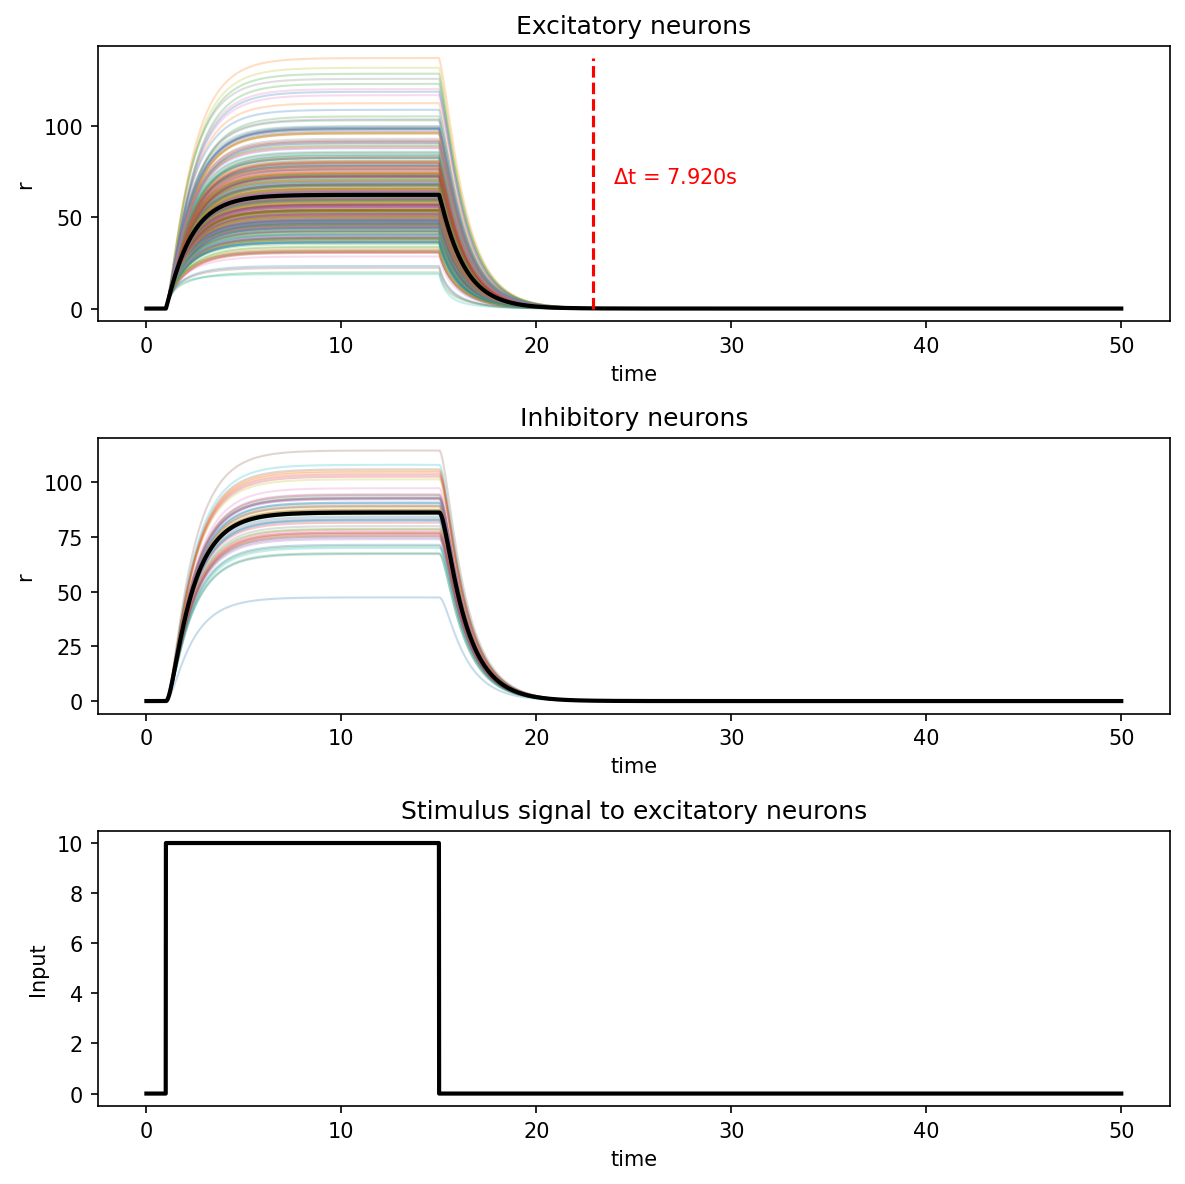

In [27]:
W = observed_plus_random_connectivity_matrix(shuffle_W_conns(remove_reciprocal(syn_mat_l23), random_seed=random_seed), r_inhibitory=r_inhibitory, g=g,
                                             connectivity_proba=connectivity_proba, random_seed=random_seed,
                                             inh_exc_balance=inh_exc_balance)
# Run simulation
r = run_simulation(W, stimulus, dt=dt)

# Plot
plot_time_series(r, stimulus, dt, r_inhibitory)

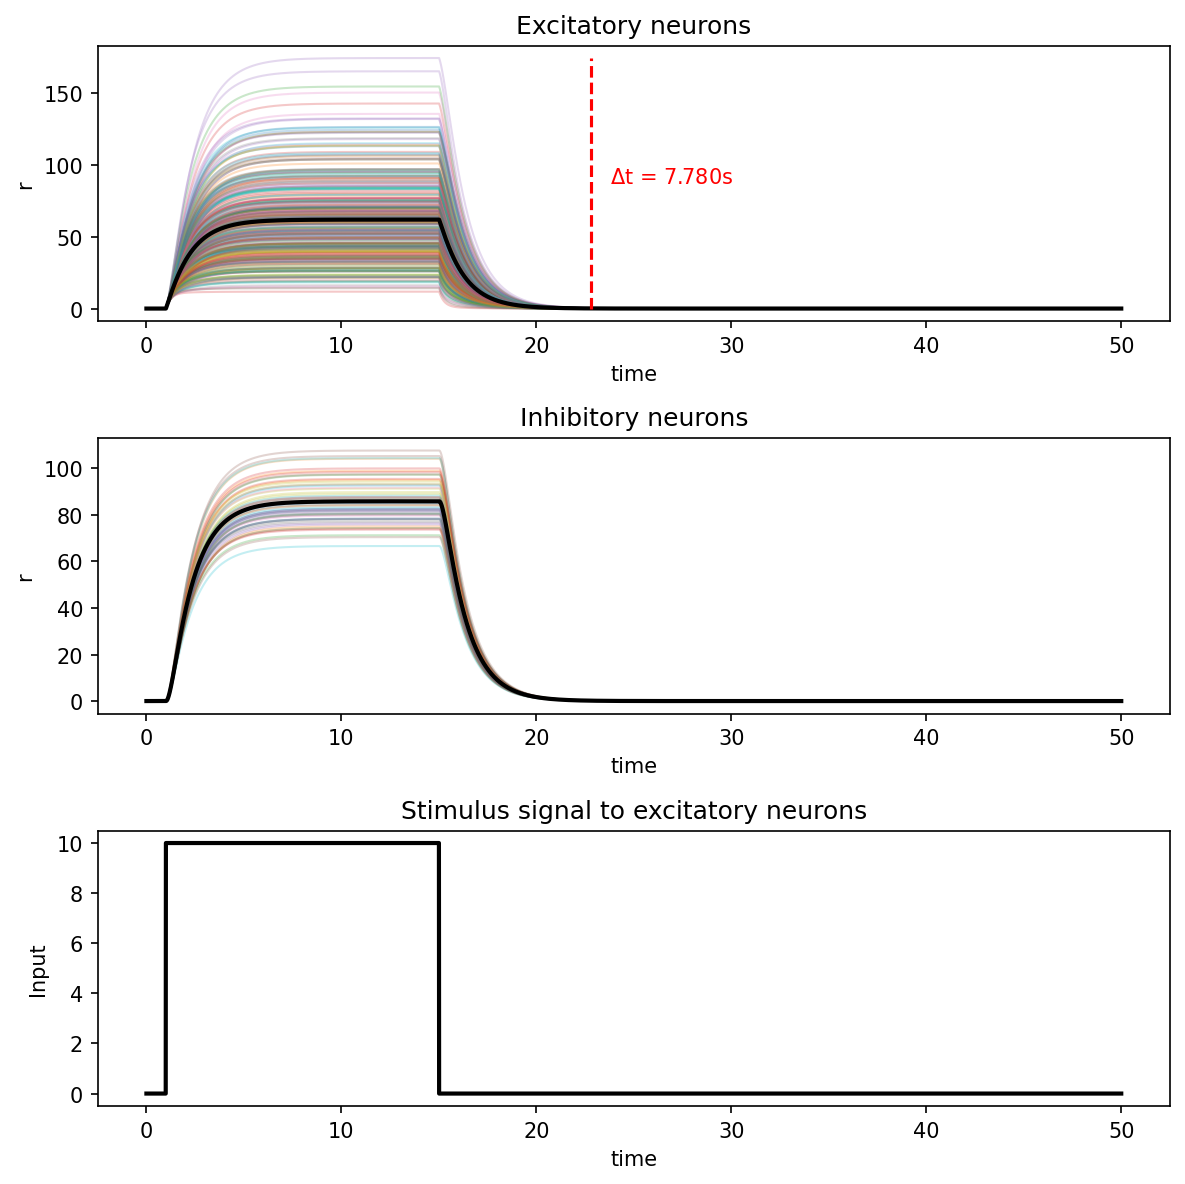

In [28]:
W = observed_plus_random_connectivity_matrix(shuffle_W_weights(remove_reciprocal(syn_mat_l23), random_seed=random_seed), r_inhibitory=r_inhibitory, g=g,
                                             connectivity_proba=connectivity_proba, random_seed=random_seed,
                                             inh_exc_balance=inh_exc_balance)

# Run simulation
r = run_simulation(W, stimulus, dt=dt)

# Plot
plot_time_series(r, stimulus, dt, r_inhibitory)